In [128]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import math
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [129]:
def RGBGray(image, rows, cols):
    imagenGray = np.zeros((rows, cols), dtype=np.uint8)
    B = image[:, :, 0] # Separa los canales de la imagen 
    G = image[:, :, 1]
    R = image[:, :, 2]

    for i in range(rows):
        for j in range(cols):
            imagenGray[i, j] = 0.299*R[i, j] + 0.587*G[i, j] + 0.114*B[i, j] # Aplica estandar NTSC

    return imagenGray

def expandImage(image, sizeKernel, dtype):
    sizeExpand = sizeKernel - 1
    rowsExpandedImage = image.shape[0] + sizeExpand
    colsExpandedImage = image.shape[1] + sizeExpand
    expandedImage = np.zeros((rowsExpandedImage, colsExpandedImage), dtype=dtype)
    # print("\nTamaño imagen expandida: " + str(rowsExpandedImage) + " x " + str(colsExpandedImage))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            expandedImage[i + int(sizeExpand / 2), j + int(sizeExpand / 2)] = image[i, j]
    
    return expandedImage

def passKernel(originalImage, expandedImage, kernel, sizeKernel):
    expandedImage = np.float64(expandedImage)
    passKernelImage = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.float64)

    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            result = 0
            for k in range(sizeKernel):
                for l in range(sizeKernel):
                    indexExpandedImagei = i + k
                    indexExpandedImagej = j + l
                    result += expandedImage[indexExpandedImagei, indexExpandedImagej] * kernel[k, l]
            passKernelImage[i, j] = result / np.sum(kernel)
            # passKernelImage[i, j] = result

    return passKernelImage	

def crossingZero(originalImage, expandedImage, sizeKernel):
    auxMatrix = np.zeros((expandedImage.shape[0], expandedImage.shape[1]), dtype=np.uint8)
    crossingZeroImage = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.uint8)
    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            for k in range(sizeKernel):
                for l in range(sizeKernel):
                    indexExpandedImagei = i + k
                    indexExpandedImagej = j + l
                    multiplication = expandedImage[i + 1, j + 1] * expandedImage[indexExpandedImagei, indexExpandedImagej]
                    if multiplication < 0:
                        auxMatrix[indexExpandedImagei, indexExpandedImagej] = np.uint8(255)

    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            crossingZeroImage[i, j] = auxMatrix[i + 1, j + 1]

    return crossingZeroImage

def crossingZeroDelta(originalImage, expandedImage, sizeKernel, delta):
    auxMatrix = np.zeros((expandedImage.shape[0], expandedImage.shape[1]), dtype=np.uint8)
    crossingZeroImage = np.zeros((originalImage.shape[0], originalImage.shape[1]), dtype=np.uint8)
    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            for k in range(sizeKernel):
                for l in range(sizeKernel):
                    indexExpandedImagei = i + k
                    indexExpandedImagej = j + l
                    difference = expandedImage[i + 1, j + 1] - expandedImage[indexExpandedImagei, indexExpandedImagej]
                    # difference = abs(expandedImage[i + 1, j + 1] - expandedImage[indexExpandedImagei, indexExpandedImagej])
                    if difference > delta:
                        auxMatrix[indexExpandedImagei, indexExpandedImagej] = np.uint8(255)

    for i in range(originalImage.shape[0]):
        for j in range(originalImage.shape[1]):
            crossingZeroImage[i, j] = auxMatrix[i + 1, j + 1]

    return crossingZeroImage

def andImage(image1, image2):
    crossingZeroImage = np.zeros((image1.shape[0], image1.shape[1]), dtype=np.uint8)
    for i in range(image1.shape[0]):
        for j in range(image1.shape[1]):
            if image1[i, j] == np.uint8(255) and image2[i, j] == np.uint8(255):
                crossingZeroImage[i, j] = np.uint8(255)

    return crossingZeroImage


In [130]:
def histogram(image):
    histogramImage = np.zeros((1, 256), dtype=np.int32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            intensity = image[i, j]
            histogramImage[0, intensity] += 1
    print("\nHistograma:\n", histogramImage)

    pixels = 0
    for i in range(256):
        pixels += histogramImage[0, i]
    print("\nPixeles totales: ", pixels, "\n")

    return histogramImage

def isoData(T, histogramImage):
    threshold = 0
    deltaT = 0.5
    difference = float(999999)
    iterations = 1
    while 1:
        print("Iteraciones: ", str(iterations)) # Numero de iteraciones 

        media1 = 0
        media2 = 0
        cluster1 = 0
        cluster2 = 0
        datacluster1 = 0
        datacluster2 = 0
        previousThreshold = threshold

        for i in range(256):
            if i <= T:
                cluster1 += histogramImage[0, i]
                media1 += i * histogramImage[0, i]
                datacluster1 += 1
            elif i > T:
                cluster2 += histogramImage[0, i]
                media2 += i * histogramImage[0, i]
                datacluster2 += 1
        print("cluster1: ", str(cluster1), "\t", "cluster2:", str(cluster2))
        print("datacluster1: ", str(datacluster1), "\t", "datacluster2:", str(datacluster2))
        # print("media1: ", str(media1), "\t", "media2:", str(media2), "\n")

        media1 = float(media1 / cluster1)
        media2 = float(media2 / cluster2)

        threshold = float((media1 + media2) / 2)
        difference = abs(threshold - previousThreshold)
        # print("media1: ", str(media1), "\t", "media2:", str(media2))
        print("threshold: ", str(threshold))
        print("diferencia: ", str(difference), "\n")

        if difference <= deltaT:
            break

        T = threshold
        iterations += 1
    print("\nThreshold: ", int(threshold))

    return int(threshold)

def otsu(histogramImage):
    variances = []
    for i in range(256):
        variance = 0 # Varianza total
        varianceB = 0 # Varianza fondo
        varianceF = 0 # Varianza frente
        weightB = 0 # Peso fondo
        weightF = 0 # Peso frente
        mediaB = 0
        mediaF = 0
        pixelsB = 0
        pixelsF = 0

        for j in range(256): # Sacamos los pesos y las medias 
            if j <= i:
                pixelsB += histogramImage[0, j]
                mediaB += j * histogramImage[0, j]
            elif j > i:
                pixelsF += histogramImage[0, j]
                mediaF += j * histogramImage[0, j]
        weightB = np.float64(pixelsB / (pixelsB + pixelsF))
        weightF = np.float64(pixelsF / (pixelsB + pixelsF))

        if pixelsB > 0: # Valida que no se hagan divisiones entre cero 
            mediaB = np.float64(mediaB / pixelsB)

        if pixelsF > 0:
            mediaF = np.float64(mediaF / pixelsF)

        for j in range(256): # Sacamos las varianzas
            if j <= i:
                varianceB += pow(j - mediaB, 2) * histogramImage[0, j]
            elif j > i:
                varianceF += pow(j - mediaF, 2) * histogramImage[0, j]

        if pixelsB > 0: # Valida que no se hagan divisiones entre cero 
            varianceB = np.float64(varianceB / pixelsB)

        if pixelsF > 0:
            varianceF = np.float64(varianceF / pixelsF)

        variance = (weightB * varianceB) + (weightF * varianceF) # Calcula la varianza total
        variances.append(variance)
    # print("\nVarianzas:\n", variances)

    threshold = variances.index(min(variances))
    print("\nThreshold: ", threshold)

    return int(threshold)

def thresholdImage(image, threshold):
    binarizedImage = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] <= threshold:
                binarizedImage[i, j] = np.uint8(0)
            elif image[i, j] > threshold:
                binarizedImage[i, j] = np.uint8(255)

    return binarizedImage

In [131]:
def whatersheding(image):
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=image)

    fig, axes = plt.subplots(ncols=3, figsize=(16, 8), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray)
    ax[1].set_title('Distances')
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    

In [132]:
image = cv2.imread("globos3.png") # Lee imagen
rows = image.shape[0]
cols = image.shape[1]
print("Tamaño imagen: " + str(rows) + " x " + str(cols))

imageGray = RGBGray(image, rows, cols) # Convierte imagen a escala de grises (NTSC)

Tamaño imagen: 128 x 128


In [133]:
sizeKernel = 0
while sizeKernel % 2 != 1 or sizeKernel == 1: # Valida el tamaño del kernel 
    sizeKernel = int(input("Ingresa un tamaño de kernel impar: "))
    if sizeKernel % 2 == 0 or sizeKernel == 1:
        print("Tamaño de kernel invalido")
sigma = float(input("Introduce un valor de sigma: ")) # Pide sigma

print("\nTamaño kernel: ", sizeKernel)
print("Sigma:", sigma)

# Creamos kernel 
kernel = np.zeros((sizeKernel, sizeKernel), dtype=np.float64)
centerKernel = (sizeKernel - 1) / 2
print("\nCentro kernel: ", str(centerKernel) + ", " + str(centerKernel))

for i in range(sizeKernel):
    y = int(-1 * (i - centerKernel))
    for j in range(sizeKernel):
        x = int(j - centerKernel)
        result = (1 / (2 * math.pi * sigma * sigma)) * pow(math.e, -((x**2 + y**2) / (2 * sigma**2))) # Gaussiano
        # result = (1 / (2 * math.pi * sigma**4)) * (2 - ((x**2 + y**2) / sigma**2)) * pow(math.e, -((x**2 + y**2) / (2 * sigma**2))) # Laplaciano del Gaussiano
        # result = -(1 / (math.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * pow(math.e, -((x**2 + y**2) / (2 * sigma**2)))
        kernel[i, j] = result

        print("\t(", str(x) + ", " + str(y) + ")", end=" ")
    print("")
print("\nKernel\n", kernel)


Tamaño kernel:  5
Sigma: 1.0

Centro kernel:  2.0, 2.0
	( -2, 2) 	( -1, 2) 	( 0, 2) 	( 1, 2) 	( 2, 2) 
	( -2, 1) 	( -1, 1) 	( 0, 1) 	( 1, 1) 	( 2, 1) 
	( -2, 0) 	( -1, 0) 	( 0, 0) 	( 1, 0) 	( 2, 0) 
	( -2, -1) 	( -1, -1) 	( 0, -1) 	( 1, -1) 	( 2, -1) 
	( -2, -2) 	( -1, -2) 	( 0, -2) 	( 1, -2) 	( 2, -2) 

Kernel
 [[0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.02153928 0.09653235 0.15915494 0.09653235 0.02153928]
 [0.01306423 0.05854983 0.09653235 0.05854983 0.01306423]
 [0.00291502 0.01306423 0.02153928 0.01306423 0.00291502]]


In [134]:
# Pasa el kernel por la imagen
matrixTest = np.zeros((4, 5), dtype=np.float64)
matrixTest[0, 0] = 5
matrixTest[0, 1] = 0
matrixTest[0, 2] = 6
matrixTest[0, 3] = 0
matrixTest[0, 4] = 4
matrixTest[1, 0] = 2
matrixTest[1, 1] = 0
matrixTest[1, 2] = 1
matrixTest[1, 3] = 0
matrixTest[1, 4] = 2
matrixTest[2, 0] = 3
matrixTest[2, 1] = 0
matrixTest[2, 2] = 5
matrixTest[2, 3] = 0
matrixTest[2, 4] = 1
matrixTest[3, 0] = 7
matrixTest[3, 1] = 0
matrixTest[3, 2] = 7
matrixTest[3, 3] = 0
matrixTest[3, 4] = 3
print(matrixTest)

expandedImage = expandImage(matrixTest, sizeKernel, np.float64) # Expande imagen 
passKernelImage = passKernel(matrixTest, expandedImage, kernel, sizeKernel) # Pasamos el kernel por la imagen 
print(expandedImage)
print(passKernelImage)

expandedImage = expandImage(imageGray, sizeKernel, np.uint8) # Expande imagen 
passKernelImage = passKernel(imageGray, expandedImage, kernel, sizeKernel) # Pasamos el kernel por la imagen 
passKernelImage = np.uint8(passKernelImage)
print("\nTamaño matriz: " + str(passKernelImage.shape[0]) + " x " + str(passKernelImage.shape[1]))
print(passKernelImage[100])

# Cruces por cero
# expandedImage = expandImage(passKernelImage, 3, np.float64)
# crossingZeroImage = crossingZero(passKernelImage, expandedImage, 3)

# delta = int(input("Ingresa un delta: "))
# crossingZeroImageDelta = crossingZeroDelta(passKernelImage, expandedImage, 3, delta)
# imageBorder = andImage(crossingZeroImage, crossingZeroImageDelta)

[[5. 0. 6. 0. 4.]
 [2. 0. 1. 0. 2.]
 [3. 0. 5. 0. 1.]
 [7. 0. 7. 0. 3.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 6. 0. 4. 0. 0.]
 [0. 0. 2. 0. 1. 0. 2. 0. 0.]
 [0. 0. 3. 0. 5. 0. 1. 0. 0.]
 [0. 0. 7. 0. 7. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1.23275015 1.36687621 1.44317341 1.24194346 1.02677086]
 [1.45342557 1.61429955 1.68761791 1.38217182 1.07071165]
 [1.71483754 1.94671398 2.02946716 1.49822993 0.97541234]
 [1.69662489 1.89347763 1.93274286 1.38092772 0.85157294]]

Tamaño matriz: 128 x 128
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   5  27  66  96 102  82  44  13   1
   0   0   0   0   0   0   6  33  78 104 103  76  32   5   0   0   0   0
   0   1  13  44  82  98  82  44  13   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

In [135]:
# Umbralizado 
histogramImage = histogram(passKernelImage) # Histograma imagen
# threshold = isoData(128, histogramImage)
threshold = otsu(histogramImage)
binarizedImage = thresholdImage(passKernelImage, threshold)


Histograma:
 [[6681   58   53   36   40  114   60   23   41    6   47    5    8   63
     2   10    7   13    7   14   17   22    5   10   20   10   18   52
     9    0    4    2   37   43    7   10   14   10    7    9    7    2
     4   10   52   14   10   15   33    9    3   16    5    4    5    9
     6   18   27    6   15    1    3    2    4   56   17   15    3    8
    11    6    1    7    1    1   39    6   42   12   10   13   55    7
     9    8    4    3    5    1    6    7    8   22   44   20   20    3
    23    4    7   22   16   56   47   10    6    5   13   20   17    5
    38   12    9    6   14    3    7    8   10   11   15   29   14   14
    20   11    4    5    6    5    1    7    4    8   12   44   10   20
    27   10   16   13 2781  172   52   34   39   26   21   25   62   20
    29   26   42   19   53   35  251 1581    1    3    5    2    4   13
     7   13   18   10    6    7   11    4    2    5    6    2    4    8
     8   10    9   47    7    4   21    9   30   1

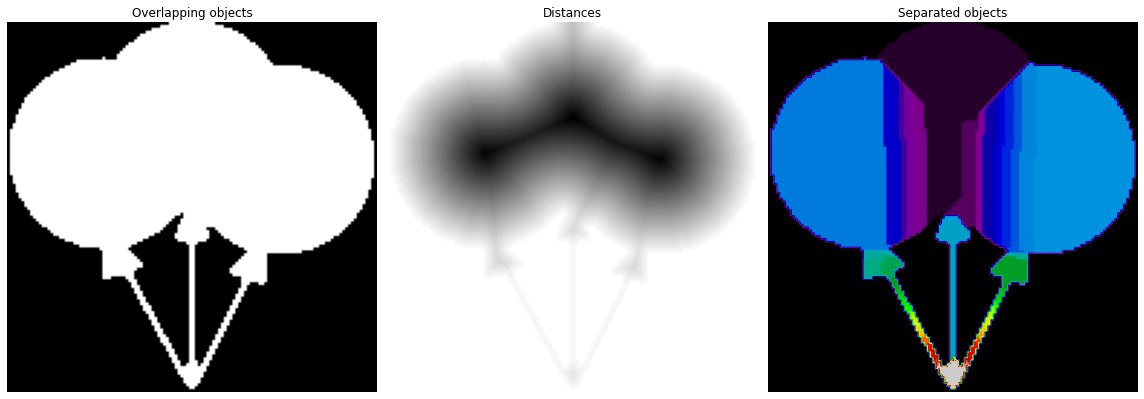

In [136]:
# whatersheding
whatersheding(binarizedImage)

In [137]:
# cv2.imshow("imagen original", image)
# cv2.imshow("Imagen escala de grises", imageGray)
# cv2.imshow("Imagen Expandida", expandedImage)
# cv2.imshow("Imagen con kernel aplicado", passKernelImage)
# cv2.imshow("Imagen Binarizada", binarizedImage)
# cv2.imshow("Imagen sin delta", crossingZeroImage)
# cv2.imshow("Imagen con delta", crossingZeroImageDelta)
# cv2.imshow("Imagen con bordes", imageBorder)
# cv2.waitKey(0)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# imageGray = cv2.cvtColor(imageGray, cv2.COLOR_BGR2RGB)
# crossingZeroImage = cv2.cvtColor(crossingZeroImage, cv2.COLOR_BGR2RGB)
# crossingZeroImageDelta = cv2.cvtColor(crossingZeroImageDelta, cv2.COLOR_BGR2RGB)
# imageBorder = cv2.cvtColor(imageBorder, cv2.COLOR_BGR2RGB)

# fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# axs[0][0].imshow(image)
# axs[0][1].imshow(imageGray, cmap='gray')
# axs[0][2].imshow(passKernelImage, cmap='gray')
# axs[1][0].imshow(crossingZeroImage, cmap='gray')
# axs[1][1].imshow(crossingZeroImageDelta, cmap='gray')
# axs[1][2].imshow(imageBorder, cmap='gray')

# for a in axs[0]:
#     a.set_axis_off()

# for a in axs[1]:
#     a.set_axis_off()

# plt.show()